# Virtual Library of Simulation Experiments:
## Test Functions and Datasets  Optimization Test Problems

Collection of datasets taken from https://www.sfu.ca/~ssurjano/optimization.html

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"

# Brainin dataset

In [3]:
@jax.jit
def brainin(x1, x2):
    x1 = 15 * x1 - 5
    x2 = 15 * x2
    
    v1 = x2 - 5.2 * x1 ** 2 / (4 * jnp.pi ** 2) + 5 * x1 / jnp.pi - 6
    v2 = (10 - 10 / (8 * jnp.pi)) * jnp.cos(x1)
    v = (v1 ** 2 + v2 - 44.81) / 51.95
    return v

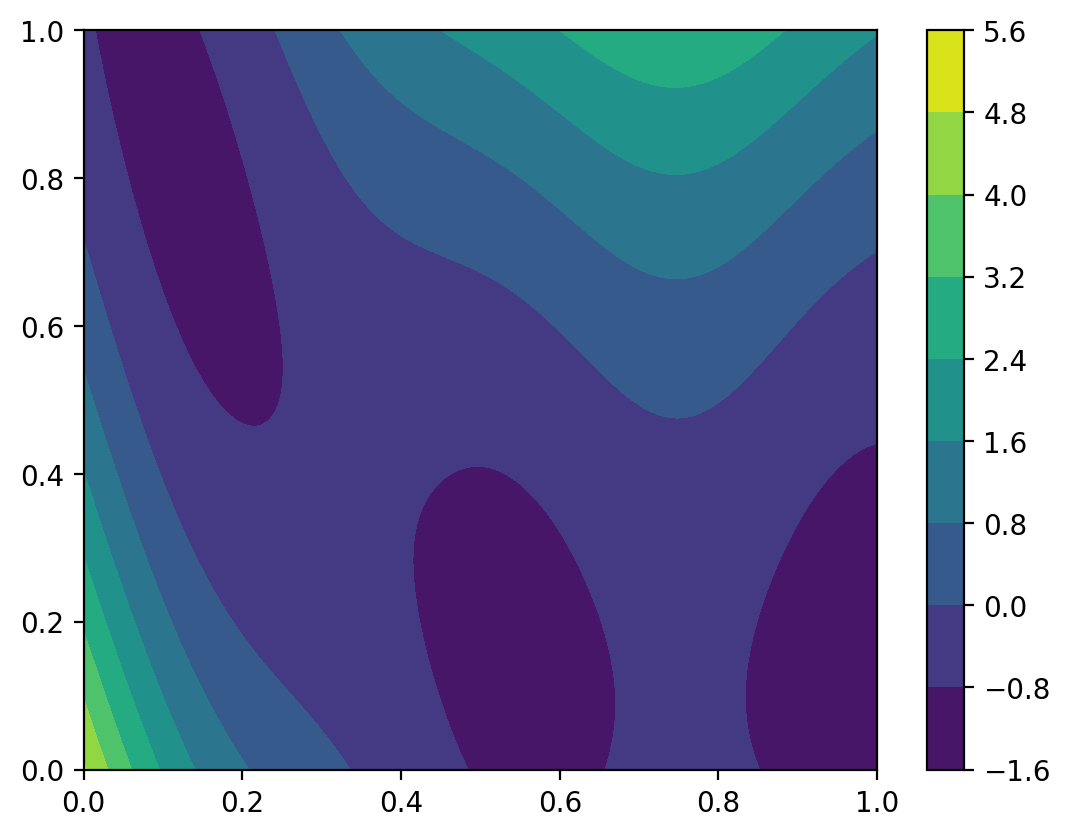

In [4]:
domain = jnp.mgrid[0:1:0.01, 0:1:0.01]
X1, X2 = domain
domain = jnp.linspace(0, 1, 100)

brainin_vmap = jax.vmap(brainin, (0, None))
brainin_vmap = jax.vmap(brainin_vmap, (None, 0))
Z = brainin_vmap(domain, domain)

plt.contourf(domain, domain, Z, cmap="viridis")
plt.colorbar()

## GPJax

In [237]:
import jax
import optax
import distrax
import gpjax as gpx
import jaxkern as jk
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxutils import Dataset
from jax.config import config
from pprint import PrettyPrinter

**The posterior probability distribution**

$$
    f(x) \vert f(x_{1:n}) \sim \cal{N}(\mu_n(x), \sigma^2_n(x)),
$$
where
$$
\begin{aligned}
    \mu_n(x) &= \Sigma_0(x, x_{1:n}) \Sigma_0(x_{1:n}, x_{1:n})^{-1} (f(x_{1:n}) - \mu_0(x_{1:n}) + \mu_0(x_{1:n})\\
    \sigma^2_n(x) &= \Sigma_0(x, x) - \Sigma_0(x, x_{1:n}) \Sigma_0(x_{1:n}, x_{1:n})^{-1} \Sigma_0(x_{1:n}, x)
\end{aligned}
$$


* The posterior mean $\mu_n(x)$ is a weighted average between the prior $\mu_0(x)$ and an estimate based on the data $f(x_{1:n})$, with a weight that depends on the kernel
* The posterior variance $\sigma^2(x)$ is equal to the prior covariance less a term that corresponds to the variance removed by observing $f(x_{1:n})$.

In [7]:
%config InlineBackend.figure_format = "retina"
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)

In [185]:
n = 10
noise = 0.0

key = jax.random.PRNGKey(3141)
x = jax.random.uniform(key=key, minval=-4.0, maxval=4.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jax.random.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-4, 4, 500).reshape(-1, 1)
ytest = f(xtest)

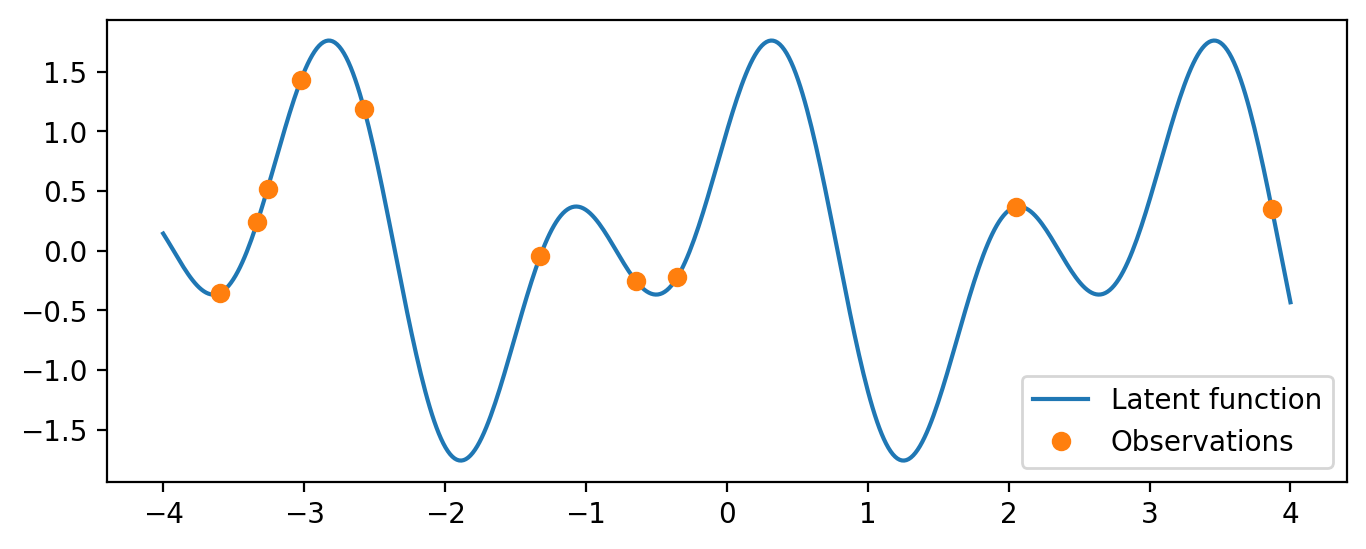

In [186]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")

In [458]:
kernel = jk.RBF()

kernel = jk.Matern32()
prior = gpx.Prior(kernel=kernel)

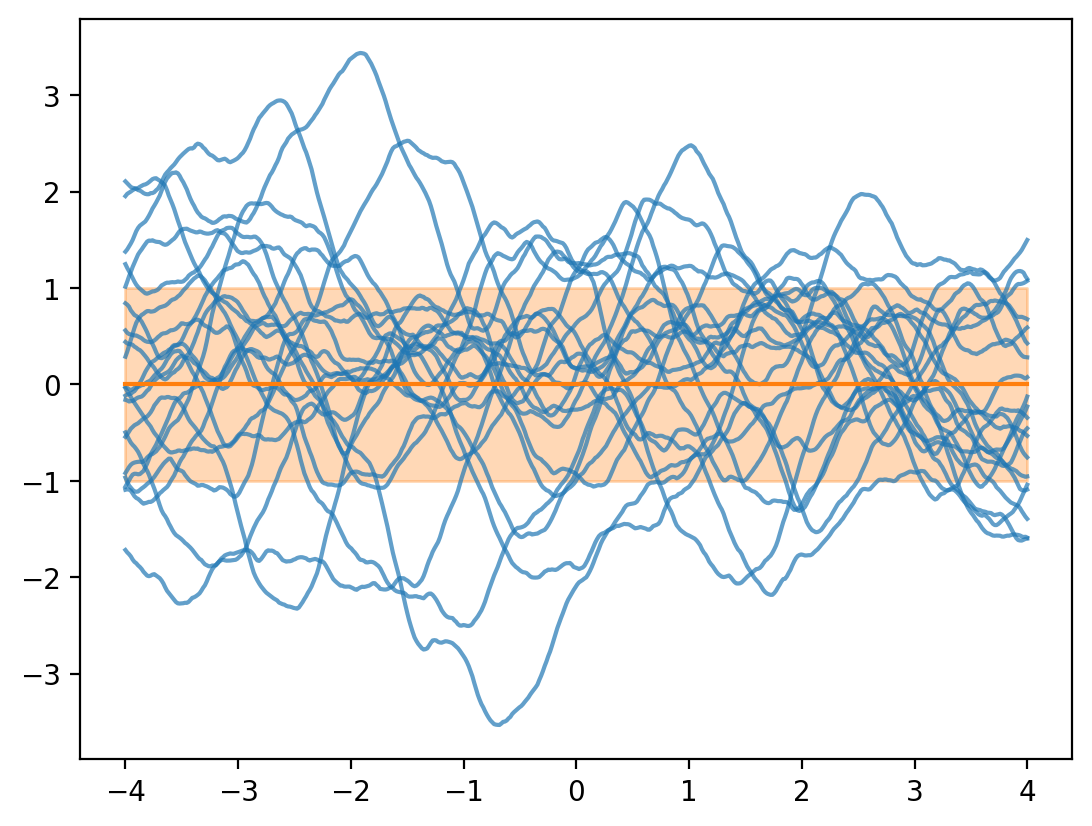

In [459]:
parameter_state = gpx.initialise(prior, key)
prior_dist = prior(parameter_state.params)(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T

plt.plot(xtest, samples, color="tab:blue", alpha=0.7)
plt.plot(xtest, prior_mean, color="tab:orange")
plt.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
plt.show()

In [460]:
likelihood = gpx.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [461]:
parameter_state = gpx.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.1])}
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


In [462]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': {   'lengthscale': Array([0.1], dtype=float64),
                  'variance': Array([1.], dtype=float64)},
    'likelihood': {'obs_noise': Array([1.], dtype=float64)},
    'mean_function': {}}


In [463]:
negative_mll = jax.jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(13.64253372, dtype=float64)

In [464]:
optimiser = optax.adam(learning_rate=0.1)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 14942.83it/s, Objective=5.91]


In [465]:
learned_params, training_history = inference_state.unpack()
learned_params

{'kernel': {'lengthscale': Array([0.5721115], dtype=float64),
  'variance': Array([0.41743813], dtype=float64)},
 'likelihood': {'obs_noise': Array([7.09717635e-05], dtype=float64)},
 'mean_function': {}}

In [466]:
latent_dist = posterior(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

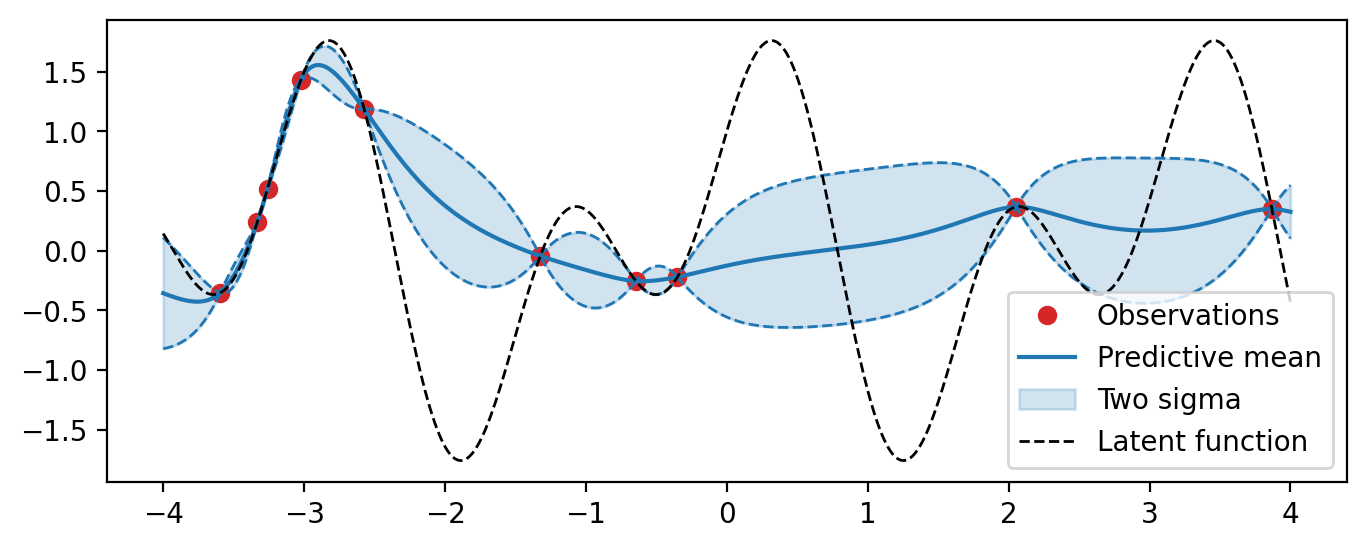

In [467]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)

lbound = predictive_mean - predictive_std
ubound = predictive_mean + predictive_std

ax.plot(xtest, lbound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ubound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1)

ax.legend()

## Prediction

In [468]:
init_params = dict(parameter_state.params)
init_params["kernel"]["lengthscale"] = 0.5
init_params["kernel"]["variance"] = 10.0
init_params["likelihood"]["obs_noise"] = 0.0

In [469]:
latent_dist = posterior(init_params, D)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

In [470]:
predictive_dist.log_prob(jnp.array([0.4]))

Array(-363490.78751354, dtype=float64)

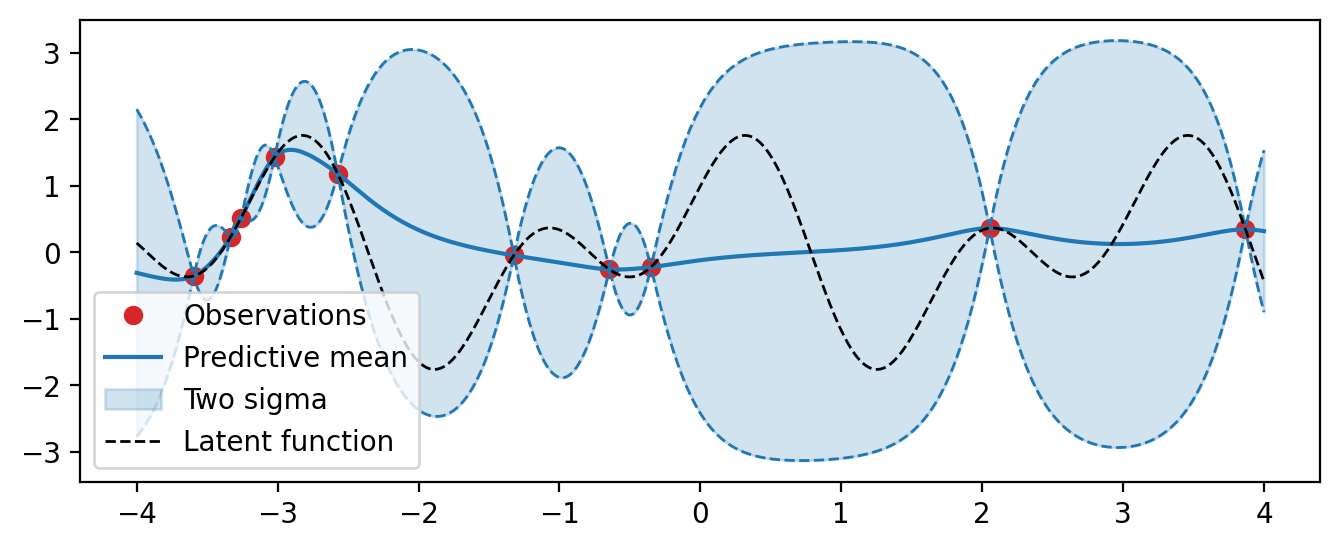

In [471]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)

lbound = predictive_mean - predictive_std
ubound = predictive_mean + predictive_std

ax.plot(xtest, lbound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ubound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1)

ax.legend()

## Expected improvement

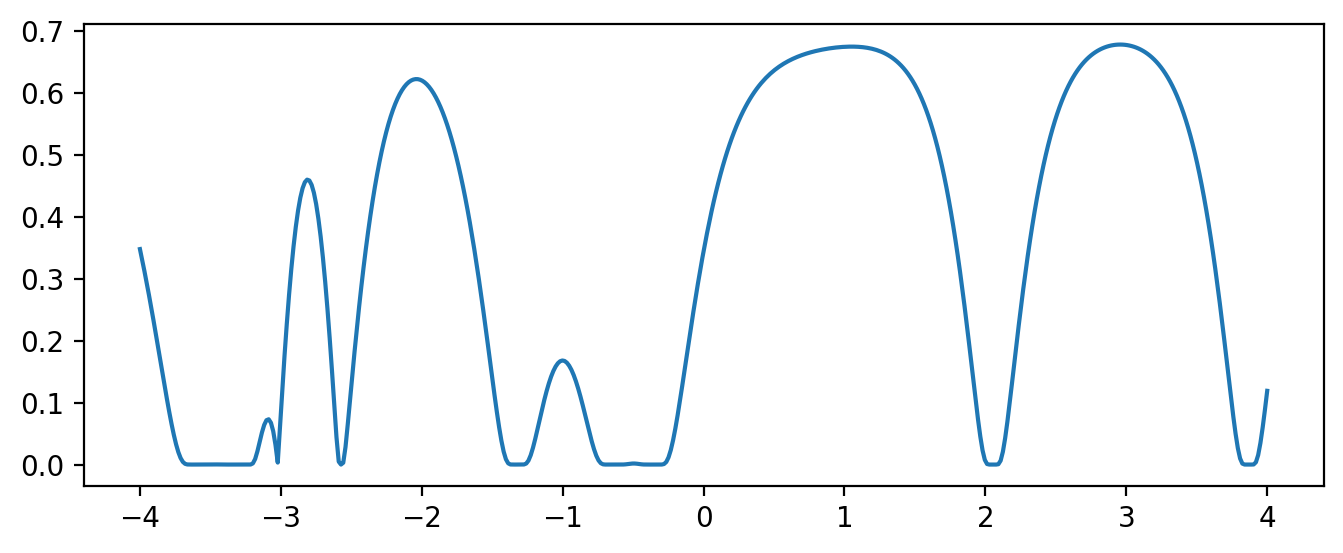

In [472]:
fig, ax = plt.subplots(figsize=(8, 3))

f_best = y.max()

latent_dist = posterior(init_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

change_f = predictive_mean - f_best


ndist = distrax.Normal(0.0, 1.0)
quotient = change_f / predictive_std
phi_quot = ndist.prob(quotient)
Phi_quot = ndist.cdf(quotient)

ei = jnp.maximum(change_f, 0) + predictive_std * phi_quot - jnp.abs(change_f) * Phi_quot
plt.plot(xtest, ei)

In [473]:
def expected_improvement(x):
    latent_dist = posterior(init_params, D)(x)
    predictive_dist = likelihood(learned_params, latent_dist)
    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    
    f_best = y.max()
    change_f = predictive_mean - f_best

    ndist = distrax.Normal(0.0, 1.0)
    quotient = change_f / predictive_std
    phi_quot = ndist.prob(quotient)
    Phi_quot = ndist.cdf(quotient)

    ei = jnp.maximum(change_f, 0.0) + predictive_std * phi_quot - jnp.abs(change_f) * Phi_quot
    return ei.sum()


In [474]:
ix_max = ei.argmax().item()

In [475]:
optimize.minimize(expected_improvement, jnp.array([0.8]), method="BFGS")

OptimizeResults(x=Array([-0.56690869], dtype=float64), success=Array(False, dtype=bool), status=Array(3, dtype=int64, weak_type=True), fun=Array(0.00011017, dtype=float64), jac=Array([0.0118313], dtype=float64), hess_inv=Array([[32.79318761]], dtype=float64), nfev=Array(8, dtype=int64, weak_type=True), njev=Array(8, dtype=int64, weak_type=True), nit=Array(1, dtype=int64, weak_type=True))

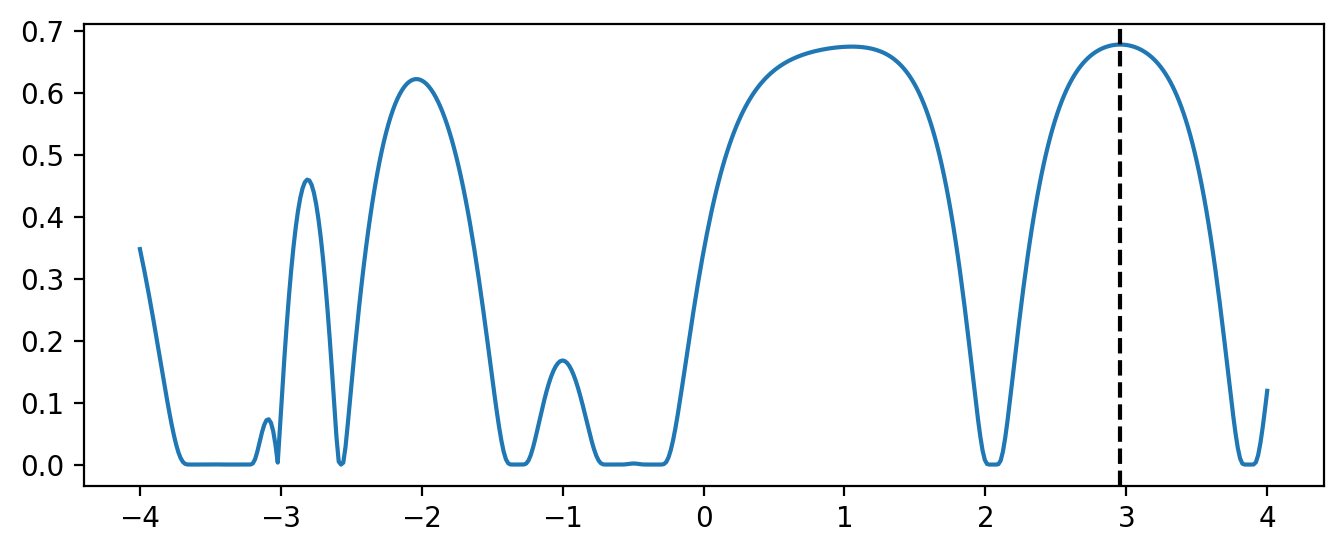

In [476]:
fig, ax = plt.subplots(figsize=(8, 3))

# ei = jnp.maximum(change_f, 0.0) + predictive_std * phi_quot - jnp.abs(change_f) * Phi_quot
ei = jax.vmap(expected_improvement)(xtest)
ix_max = ei.argmax()
plt.plot(xtest, ei)
plt.axvline(x=xtest[ix_max], c="black", linestyle="--")

### Take next point

In [477]:
x_eval = xtest[ix_max]
x_next = jnp.concatenate([x, x_eval[:, None]])

y_next = jnp.concatenate([y.ravel(), f(x_eval)])[:, None]

In [478]:
D_next = Dataset(X=x_next, y=y_next)

latent_dist = posterior(init_params, D_next)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()



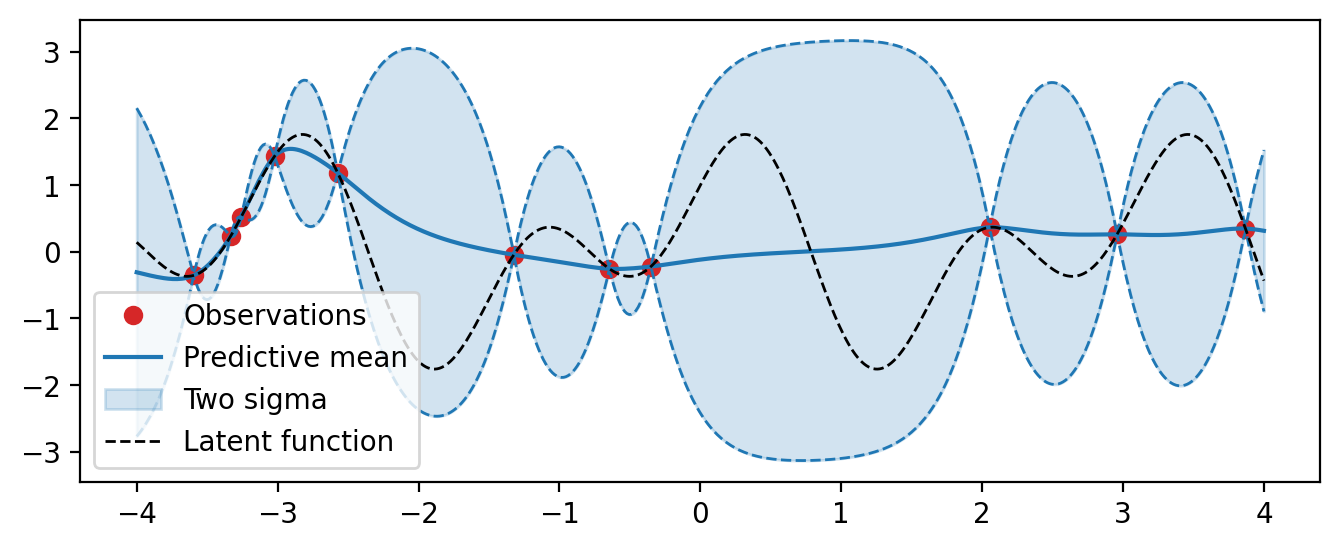

In [479]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_next, y_next, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)

lbound = predictive_mean - predictive_std
ubound = predictive_mean + predictive_std

ax.plot(xtest, lbound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ubound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1)

ax.legend()